<a href="https://colab.research.google.com/github/KS0999/ML/blob/main/ComputerVision_GPU.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [124]:
import torch
from torch import nn
import torchvision
from torchvision import datasets
from torchvision import transforms
from torchvision.transforms import ToTensor
from torch.utils.data import DataLoader
from matplotlib import pyplot as plt
import numpy as np
import os
import pathlib as path
import requests

In [125]:
train_dataset = torchvision.datasets.FashionMNIST(root="data",
                                                  train=True,
                                                  download=True,
                                                  transform=torchvision.transforms.ToTensor())
test_dataset = torchvision.datasets.FashionMNIST(root="data",
                                                  train=False,
                                                  download=True,
                                                  transform=torchvision.transforms.ToTensor())

In [126]:
train_class = train_dataset.classes
train_class

['T-shirt/top',
 'Trouser',
 'Pullover',
 'Dress',
 'Coat',
 'Sandal',
 'Shirt',
 'Sneaker',
 'Bag',
 'Ankle boot']

In [127]:
train_label = train_dataset.class_to_idx
train_label

{'T-shirt/top': 0,
 'Trouser': 1,
 'Pullover': 2,
 'Dress': 3,
 'Coat': 4,
 'Sandal': 5,
 'Shirt': 6,
 'Sneaker': 7,
 'Bag': 8,
 'Ankle boot': 9}

(-0.5, 27.5, 27.5, -0.5)

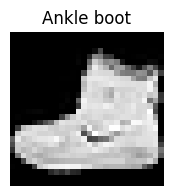

In [128]:
plt.figure(figsize = (2,2))
image,label = train_dataset[0]
plt.imshow(image.squeeze(),cmap = "gray")
plt.title(train_class[label])
plt.axis(False)

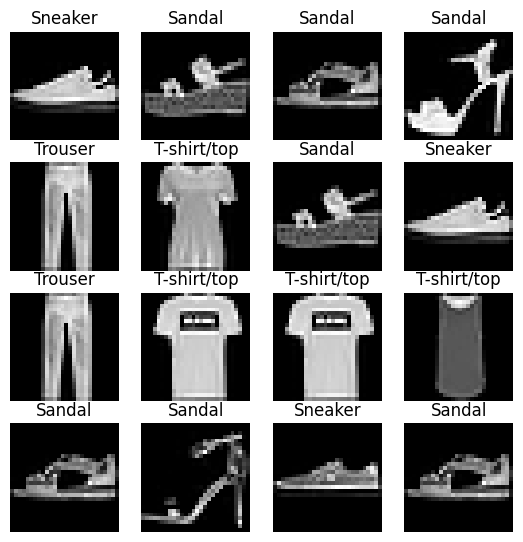

In [129]:
row,col = 4,4
plt.figure(figsize=(6.5,6.5))
for index in range(1,row*col+1):
  random = torch.randint(1,row*col+1,size = [1]).item()
  image,label = train_dataset[random]
  plt.subplot(row,col,index)
  plt.title(train_class[label])
  plt.axis(False)
  plt.imshow(image.squeeze(),cmap = "gray")


In [130]:
Batch_size = 32
train_dataloader = torch.utils.data.DataLoader(dataset = train_dataset,
                                               batch_size = Batch_size,
                                               shuffle = True)
test_dataloader = torch.utils.data.DataLoader(dataset = test_dataset,
                                               batch_size = Batch_size,
                                               shuffle = False)
print(len(train_dataset))
print(len(test_dataset))
print(len(train_dataloader))
print(len(test_dataloader))

60000
10000
1875
313


In [131]:
if os.path.isfile("helper_functions.py"):
  print("helper_functions.py is exist!")
else:
  print("helper_functions.py is not exist! Preparing for downloading ...")
  url = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/helper_functions.py")
  with open("helper_functions.py","wb") as file:
    file.write(url.content)

helper_functions.py is exist!


In [132]:
image,label = train_dataset[1]
model = nn.Flatten()
print(image.shape)
print(model(image).shape)

torch.Size([1, 28, 28])
torch.Size([1, 784])


In [133]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [134]:
class FashionMNIST(nn.Module):
  def __init__(self,input_shape,output_shape,hidden_units):
    super().__init__()
    self.layer = nn.Sequential(
        nn.Flatten(),
        nn.Linear(in_features=input_shape,out_features=hidden_units),
        nn.ReLU(),
        nn.Linear(in_features=hidden_units,out_features=hidden_units),
        nn.ReLU(),
        nn.Linear(in_features=hidden_units,out_features=hidden_units),
        nn.ReLU(),
        nn.Linear(in_features=hidden_units,out_features=output_shape),
    )
  def forward(self,x):
    return self.layer(x)

model_v1 = FashionMNIST (input_shape = 28*28,
                         output_shape = len(train_label),
                         hidden_units = 10).to(device)
model_v1.state_dict()

OrderedDict([('layer.1.weight',
              tensor([[ 0.0052, -0.0001,  0.0312,  ..., -0.0127, -0.0012, -0.0216],
                      [ 0.0082,  0.0330,  0.0224,  ...,  0.0027,  0.0016, -0.0277],
                      [ 0.0036,  0.0347,  0.0019,  ..., -0.0249,  0.0046,  0.0142],
                      ...,
                      [ 0.0142,  0.0272, -0.0267,  ...,  0.0012,  0.0024,  0.0172],
                      [ 0.0135,  0.0225, -0.0108,  ...,  0.0119,  0.0053, -0.0057],
                      [-0.0273,  0.0040, -0.0131,  ...,  0.0163,  0.0103,  0.0022]],
                     device='cuda:0')),
             ('layer.1.bias',
              tensor([ 0.0210,  0.0342, -0.0055,  0.0198,  0.0160, -0.0148, -0.0306,  0.0013,
                      -0.0179, -0.0222], device='cuda:0')),
             ('layer.3.weight',
              tensor([[-0.2146, -0.3015, -0.2045, -0.1087, -0.0241,  0.1859,  0.0989,  0.1570,
                       -0.0893,  0.0470],
                      [ 0.3122,  0.1545,  0

In [135]:
# Accuracy functions
from helper_functions import accuracy_fn
# Loss functions
loss_fn = torch.nn.CrossEntropyLoss()
# Optimizer
optimizer = torch.optim.SGD(lr = 0.1,
                            params=model_v1.parameters())

In [136]:
from timeit import default_timer as timer
def calculate_time(start : float,
                   end : float,
                   device : torch.device):
  total_time = end - start
  print(f"Now running on {device} . All progress take {total_time} seconds.")
  return total_time

In [137]:
import torch

train_dataloader = [ (data.to(device), labels.to(device)) for data, labels in train_dataloader]
test_dataloader = [ (data.to(device), labels.to(device)) for data, labels in test_dataloader]

In [138]:
from tqdm.auto import tqdm
torch.manual_seed(1)

epochs = 3
train_time_start = timer()

for epoch in tqdm(range(epochs)):
  print(f"----------EPOCH {epoch}----------\n")
  train_loss = 0

  for batch,(X,y) in enumerate(train_dataloader):
    model_v1.train()
    # do the forwardpass
    y_pred = model_v1(X)

    # calculate the loss
    loss = loss_fn(y_pred,y)
    train_loss += loss

    # optimizer zero grad
    optimizer.zero_grad()

    # loss backward
    loss.backward()

    # optimizer step
    optimizer.step()
    if batch % 400 ==0:
      print(f"Loading {batch*len(X)}/{len(train_dataset)}...\n")
  train_loss /= len(train_dataloader)

  model_v1.eval()
  test_loss,test_acc = 0,0
  with torch.inference_mode():
    for X,y in test_dataloader:
      # do the forward pass
      test_pred = model_v1(X)

      # calculate the loss & acc
      test_loss += loss_fn(test_pred,y)
      test_acc += accuracy_fn (y_true = y,
                               y_pred = torch.argmax(test_pred,dim = 1))
    test_loss /= len(test_dataloader)
    test_acc /= len(test_dataloader)
    # All train & evaluate result
  print(f" Train_Loss : {train_loss:.5f}, Test_Loss : {test_loss:.5f}, Test_Accuracy : {test_acc:.2f}%\n")

train_time_end = timer()
train_time_total = calculate_time(start = train_time_start,
                                  end = train_time_end,
                                  device = str(next(model_v1.parameters()).device))

  0%|          | 0/3 [00:00<?, ?it/s]

----------EPOCH 0----------

Loading 0/60000...

Loading 12800/60000...

Loading 25600/60000...

Loading 38400/60000...

Loading 51200/60000...

 Train_Loss : 0.89590, Test_Loss : 0.64223, Test_Accuracy : 76.75%

----------EPOCH 1----------

Loading 0/60000...

Loading 12800/60000...

Loading 25600/60000...

Loading 38400/60000...

Loading 51200/60000...

 Train_Loss : 0.53999, Test_Loss : 0.51263, Test_Accuracy : 81.32%

----------EPOCH 2----------

Loading 0/60000...

Loading 12800/60000...

Loading 25600/60000...

Loading 38400/60000...

Loading 51200/60000...

 Train_Loss : 0.49267, Test_Loss : 0.50622, Test_Accuracy : 81.78%

Now running on cuda:0 . All progress take 14.288280886999928 seconds.


In [139]:
def eval_model_dict(model : torch.nn.Module,
                    loss : torch.nn.Module,
                    dataloader : torch.utils.data.DataLoader,
                    accuracy_fn):
  model.eval()
  loss, acc = 0, 0
  with torch.inference_mode():
    for X,y in tqdm(dataloader):
      # do the forward pass
      y_pred = model(X)
      # calculate the loss & accuracy
      loss += loss_fn(y_pred, y)
      acc += accuracy_fn(y_true = y,
                        y_pred = torch.argmax(y_pred, dim = 1))
    loss /= len(dataloader)
    acc /= len(dataloader)
  return {
      "Model" :model.__class__.__name__,
      "Loss" : loss.item(),
      "Accuarcy" : acc,
  }

In [140]:
eval_test_dict = eval_model_dict(model = model_v1,
                            loss = loss_fn,
                            dataloader = test_dataloader,
                            accuracy_fn = accuracy_fn)
eval_test_dict

  0%|          | 0/313 [00:00<?, ?it/s]

{'Model': 'FashionMNIST',
 'Loss': 0.5062181949615479,
 'Accuarcy': 81.77915335463258}

In [141]:
def train_model(epochs : int,
                dataloader : torch.utils.data.DataLoader,
                model : torch.nn.Module,
                loss_fn : torch.nn.Module,
                optimizer : torch.optim.Optimizer,
                device : torch.device = device):
  from tqdm.auto import tqdm

  train_start = timer()
  epochs = epochs

  for epoch in tqdm(range(epochs)):
    print(f"---------- EPOCH {epoch} ----------\n")
    train_loss, train_acc = 0,0
    for batch,(X,y) in enumerate(dataloader):
      X,y = X.to(device),y.to(device)
      # setting model train
      model.train()

      # do the forward pass
      y_pred = model(X)
      # calculate the loss
      loss = loss_fn(y_pred,y)
      acc = accuracy_fn(y_true = y,
                        y_pred = torch.argmax(y_pred,dim = 1))
      train_loss += loss
      train_acc += acc
      # optimizer zero grad
      optimizer.zero_grad()
      # loss backward
      loss.backward()
      # optimizer step
      optimizer.step()
    train_loss /= len(dataloader)
    train_acc /= len(dataloader)
    print(f"Train_loss : {train_loss.item()}, Train_Accuracy : {train_acc:.2f} %\n")
    train_end = timer()
  train_total = calculate_time(start = train_start,
                               end = train_end,
                               device = str(next(model.parameters()).device))

In [142]:
def eval_model(epoch : int,
               model : torch.nn.Module,
               loss : torch.nn.Module,
               dataloader : torch.utils.data.DataLoader,
               accuracy_fn):
  model.eval()
  from timeit import default_timer as timer
  from tqdm.auto import tqdm

  eval_start = timer()
  epochs = epoch
  test_loss, test_acc = 0, 0
  for epoch in tqdm(range(epochs)):
    with torch.inference_mode():
      for X,y in dataloader :
        X,y = X.to(device),y.to(device)
        # do the forward pass
        test_pred = model(X)
        # calculate the loss & accuracy
        test_loss += loss_fn(test_pred, y)
        test_acc += accuracy_fn(y_true = y,
                                y_pred = torch.argmax(test_pred, dim = 1))
      test_loss /= len(dataloader)
      test_acc /= len(dataloader)
    print(f" Test_Loss : {test_loss.item()} , Test_Accuracy : {test_acc:.2f} %\n")
    eval_end = timer()

  eval_test = calculate_time(start = eval_start,
                             end = eval_end,
                             device =str(next(model_v1.parameters()).device))

In [143]:
model_test= train_model(epochs = 3 ,
                        dataloader = train_dataloader,
                        model = model_v1,
                        loss_fn = torch.nn.CrossEntropyLoss(),
                        optimizer = torch.optim.SGD(lr = 0.1,
                                                    params = model_v1.parameters()))
model_test

  0%|          | 0/3 [00:00<?, ?it/s]

---------- EPOCH 0 ----------

Train_loss : 0.46801093220710754, Train_Accuracy : 83.38 %

---------- EPOCH 1 ----------

Train_loss : 0.449840247631073, Train_Accuracy : 84.10 %

---------- EPOCH 2 ----------

Train_loss : 0.43557292222976685, Train_Accuracy : 84.66 %

Now running on cuda:0 . All progress take 11.155483307000395 seconds.


In [144]:
eval_test = eval_model(epoch = 3,
                       model = model_v1,
                       loss = torch.nn.CrossEntropyLoss(),
                       dataloader = test_dataloader,
                       accuracy_fn = accuracy_fn)
eval_test

  0%|          | 0/3 [00:00<?, ?it/s]

 Test_Loss : 0.4806760251522064 , Test_Accuracy : 82.45 %

 Test_Loss : 0.48221173882484436 , Test_Accuracy : 82.71 %

 Test_Loss : 0.4822166860103607 , Test_Accuracy : 82.71 %

Now running on cuda:0 . All progress take 0.4055773219997718 seconds.


In [145]:
train_result = eval_model_dict(model = model_v1,
                               loss = torch.nn.CrossEntropyLoss(),
                               dataloader = train_dataloader,
                               accuracy_fn = accuracy_fn)
train_result

  0%|          | 0/1875 [00:00<?, ?it/s]

{'Model': 'FashionMNIST', 'Loss': 0.4260580837726593, 'Accuarcy': 84.38}

In [146]:
test_result = eval_model_dict(model = model_v1,
                               loss = torch.nn.CrossEntropyLoss(),
                               dataloader = test_dataloader,
                               accuracy_fn = accuracy_fn)
test_result

  0%|          | 0/313 [00:00<?, ?it/s]

{'Model': 'FashionMNIST',
 'Loss': 0.4806760251522064,
 'Accuarcy': 82.44808306709265}